## 주가 예측을 위한 LSTM 모델 작성

In [1]:
!pip install pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.layers import Dropout, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf

### 데이터 수집

In [3]:
# 2005 ~ 2022까지의 데이터 불러오기
start = '2005-01-01'
end = '2022-03-18'

df = data.DataReader('MSFT.US', 'stooq', start, end)
df.to_csv('MICROSOFT.csv') # csv 파일로 생성

In [4]:
df = pd.read_csv('MICROSOFT.csv')
df

,Date,Open,High,Low,Close,Volume
0,2022-03-18,295.370,301.0000,292.730,300.430,43390625.0
1,2022-03-17,293.290,295.6100,289.370,295.220,30816633.0
2,2022-03-16,289.110,294.5700,283.200,294.390,37826329.0
3,2022-03-15,280.350,287.8200,278.725,287.150,34245085.0
4,2022-03-14,280.340,285.3992,275.820,276.440,30660747.0
...,...,...,...,...,...,...
4328,2005-01-07,21.326,21.3680,21.152,21.189,86684119.0
4329,2005-01-06,21.316,21.5000,21.167,21.254,96769783.0
4330,2005-01-05,21.309,21.5310,21.263,21.280,91223421.0
4331,2005-01-04,21.247,21.5310,21.180,21.326,137881761.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4333 non-null   object 
 1   Open    4333 non-null   float64
 2   High    4333 non-null   float64
 3   Low     4333 non-null   float64
 4   Close   4333 non-null   float64
 5   Volume  4332 non-null   float64
dtypes: float64(5), object(1)
memory usage: 203.2+ KB


### 데이터 전처리

In [6]:
# datetime 자료형으로 변경
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4333 non-null   datetime64[ns]
 1   Open    4333 non-null   float64       
 2   High    4333 non-null   float64       
 3   Low     4333 non-null   float64       
 4   Close   4333 non-null   float64       
 5   Volume  4332 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 203.2 KB


In [7]:
# 요일정보 추가 (월:0, 화:1, 수:2, 목:3, 금:4) - 주가는 평일에만 열리니까
df['weekday'] = df['Date'].dt.weekday
df

,Date,Open,High,Low,Close,Volume,weekday
0,2022-03-18,295.370,301.0000,292.730,300.430,43390625.0,4
1,2022-03-17,293.290,295.6100,289.370,295.220,30816633.0,3
2,2022-03-16,289.110,294.5700,283.200,294.390,37826329.0,2
3,2022-03-15,280.350,287.8200,278.725,287.150,34245085.0,1
4,2022-03-14,280.340,285.3992,275.820,276.440,30660747.0,0
...,...,...,...,...,...,...,...
4328,2005-01-07,21.326,21.3680,21.152,21.189,86684119.0,4
4329,2005-01-06,21.316,21.5000,21.167,21.254,96769783.0,3
4330,2005-01-05,21.309,21.5310,21.263,21.280,91223421.0,2
4331,2005-01-04,21.247,21.5310,21.180,21.326,137881761.0,1


In [8]:
# 시작 주로부터 몇 번째 주인지 궁금 (timedelta - 두 개의 시간이나 날짜 차이 구하는 거)
start = datetime(2005, 1, 3)
df['weeks'] = (df['Date'] - start) // timedelta(weeks = 1)
df

,Date,Open,High,Low,Close,Volume,weekday,weeks
0,2022-03-18,295.370,301.0000,292.730,300.430,43390625.0,4,897
1,2022-03-17,293.290,295.6100,289.370,295.220,30816633.0,3,897
2,2022-03-16,289.110,294.5700,283.200,294.390,37826329.0,2,897
3,2022-03-15,280.350,287.8200,278.725,287.150,34245085.0,1,897
4,2022-03-14,280.340,285.3992,275.820,276.440,30660747.0,0,897
...,...,...,...,...,...,...,...,...
4328,2005-01-07,21.326,21.3680,21.152,21.189,86684119.0,4,0
4329,2005-01-06,21.316,21.5000,21.167,21.254,96769783.0,3,0
4330,2005-01-05,21.309,21.5310,21.263,21.280,91223421.0,2,0
4331,2005-01-04,21.247,21.5310,21.180,21.326,137881761.0,1,0


In [9]:
df = df[['Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close']]
df

,Date,weeks,weekday,High,Low,Open,Close
0,2022-03-18,897,4,301.0000,292.730,295.370,300.430
1,2022-03-17,897,3,295.6100,289.370,293.290,295.220
2,2022-03-16,897,2,294.5700,283.200,289.110,294.390
3,2022-03-15,897,1,287.8200,278.725,280.350,287.150
4,2022-03-14,897,0,285.3992,275.820,280.340,276.440
...,...,...,...,...,...,...,...
4328,2005-01-07,0,4,21.3680,21.152,21.326,21.189
4329,2005-01-06,0,3,21.5000,21.167,21.316,21.254
4330,2005-01-05,0,2,21.5310,21.263,21.309,21.280
4331,2005-01-04,0,1,21.5310,21.180,21.247,21.326


In [10]:
# 가장 오래된 날짜를 먼저 표시되도록 변경
df.sort_values(by = 'Date', ascending = True, inplace = True)
df

C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Date,weeks,weekday,High,Low,Open,Close
4332,2005-01-03,0,0,21.4160,21.173,21.296,21.247
4331,2005-01-04,0,1,21.5310,21.180,21.247,21.326
4330,2005-01-05,0,2,21.5310,21.263,21.309,21.280
4329,2005-01-06,0,3,21.5000,21.167,21.316,21.254
4328,2005-01-07,0,4,21.3680,21.152,21.326,21.189
...,...,...,...,...,...,...,...
4,2022-03-14,897,0,285.3992,275.820,280.340,276.440
3,2022-03-15,897,1,287.8200,278.725,280.350,287.150
2,2022-03-16,897,2,294.5700,283.200,289.110,294.390
1,2022-03-17,897,3,295.6100,289.370,293.290,295.220


In [11]:
# Date 컬럼을 인덱스로 설정
df.set_index(keys = 'Date', inplace = True)
df

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,0,0,21.4160,21.173,21.296,21.247
2005-01-04,0,1,21.5310,21.180,21.247,21.326
2005-01-05,0,2,21.5310,21.263,21.309,21.280
2005-01-06,0,3,21.5000,21.167,21.316,21.254
2005-01-07,0,4,21.3680,21.152,21.326,21.189
...,...,...,...,...,...,...
2022-03-14,897,0,285.3992,275.820,280.340,276.440
2022-03-15,897,1,287.8200,278.725,280.350,287.150
2022-03-16,897,2,294.5700,283.200,289.110,294.390


In [12]:
# 다음날의 종가와 당일의 종가의 차를 계산하여 새로운 컬럼으로 추가
df_new = df.shift(-1)
df_new

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,0.0,1.0,21.531,21.180,21.247,21.326
2005-01-04,0.0,2.0,21.531,21.263,21.309,21.280
2005-01-05,0.0,3.0,21.500,21.167,21.316,21.254
2005-01-06,0.0,4.0,21.368,21.152,21.326,21.189
2005-01-07,1.0,0.0,21.341,21.088,21.098,21.296
...,...,...,...,...,...,...
2022-03-14,897.0,1.0,287.820,278.725,280.350,287.150
2022-03-15,897.0,2.0,294.570,283.200,289.110,294.390
2022-03-16,897.0,3.0,295.610,289.370,293.290,295.220


In [13]:
df['Gap_close'] = df_new['Close'] - df['Close']
df

C:\Users\user\AppData\Local\Temp/ipykernel_12788/2306943623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gap_close'] = df_new['Close'] - df['Close']


,weeks,weekday,High,Low,Open,Close,Gap_close
Date,,,,,,,
2005-01-03,0,0,21.4160,21.173,21.296,21.247,0.079
2005-01-04,0,1,21.5310,21.180,21.247,21.326,-0.046
2005-01-05,0,2,21.5310,21.263,21.309,21.280,-0.026
2005-01-06,0,3,21.5000,21.167,21.316,21.254,-0.065
2005-01-07,0,4,21.3680,21.152,21.326,21.189,0.107
...,...,...,...,...,...,...,...
2022-03-14,897,0,285.3992,275.820,280.340,276.440,10.710
2022-03-15,897,1,287.8200,278.725,280.350,287.150,7.240
2022-03-16,897,2,294.5700,283.200,289.110,294.390,0.830


In [14]:
# 새로운 컬럼 Up을 추가하고, 다음날의 시작가가 올라간다면:1, 내려간다면:0
df.loc[df['Gap_close'] > 0, 'Up'] = 1
df.loc[df['Gap_close'] < 0, 'Up'] = 0
df

,weeks,weekday,High,Low,Open,Close,Gap_close,Up
Date,,,,,,,,
2005-01-03,0,0,21.4160,21.173,21.296,21.247,0.079,1.0
2005-01-04,0,1,21.5310,21.180,21.247,21.326,-0.046,0.0
2005-01-05,0,2,21.5310,21.263,21.309,21.280,-0.026,0.0
2005-01-06,0,3,21.5000,21.167,21.316,21.254,-0.065,0.0
2005-01-07,0,4,21.3680,21.152,21.326,21.189,0.107,1.0
...,...,...,...,...,...,...,...,...
2022-03-14,897,0,285.3992,275.820,280.340,276.440,10.710,1.0
2022-03-15,897,1,287.8200,278.725,280.350,287.150,7.240,1.0
2022-03-16,897,2,294.5700,283.200,289.110,294.390,0.830,1.0


In [15]:
# Up 칼럼을 만들었으니 Gap_close 컬럼 삭제
df.drop(['Gap_close'], axis = 1, inplace = True)
df

,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,0,0,21.4160,21.173,21.296,21.247,1.0
2005-01-04,0,1,21.5310,21.180,21.247,21.326,0.0
2005-01-05,0,2,21.5310,21.263,21.309,21.280,0.0
2005-01-06,0,3,21.5000,21.167,21.316,21.254,0.0
2005-01-07,0,4,21.3680,21.152,21.326,21.189,1.0
...,...,...,...,...,...,...,...
2022-03-14,897,0,285.3992,275.820,280.340,276.440,1.0
2022-03-15,897,1,287.8200,278.725,280.350,287.150,1.0
2022-03-16,897,2,294.5700,283.200,289.110,294.390,1.0


In [16]:
df['Up'].value_counts()

1.0    2227
0.0    2054
Name: Up, dtype: int64

<AxesSubplot:xlabel='Date'>

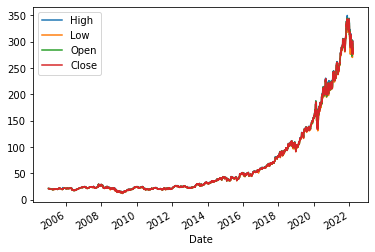

In [17]:
# High, Low, Open, Close -> line graph로 그려보기
df_graph = df[['High', 'Low', 'Open', 'Close']]
df_graph.plot(kind = 'line')

In [18]:
# 어느 정도 값이 증가했는지(비율)
df_shift = df.shift(1)
df_shift

,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,0.0,0.0,21.4160,21.173,21.296,21.247,1.0
2005-01-05,0.0,1.0,21.5310,21.180,21.247,21.326,0.0
2005-01-06,0.0,2.0,21.5310,21.263,21.309,21.280,0.0
2005-01-07,0.0,3.0,21.5000,21.167,21.316,21.254,0.0
...,...,...,...,...,...,...,...
2022-03-14,896.0,4.0,289.5100,279.430,287.960,280.070,0.0
2022-03-15,897.0,0.0,285.3992,275.820,280.340,276.440,1.0
2022-03-16,897.0,1.0,287.8200,278.725,280.350,287.150,1.0


In [19]:
df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
2005-01-03,0,0,21.4160,21.173,21.296,21.247,1.0,NaN
2005-01-04,0,1,21.5310,21.180,21.247,21.326,0.0,0.003718
2005-01-05,0,2,21.5310,21.263,21.309,21.280,0.0,-0.002157
2005-01-06,0,3,21.5000,21.167,21.316,21.254,0.0,-0.001222
2005-01-07,0,4,21.3680,21.152,21.326,21.189,1.0,-0.003058
...,...,...,...,...,...,...,...,...
2022-03-14,897,0,285.3992,275.820,280.340,276.440,1.0,-0.012961
2022-03-15,897,1,287.8200,278.725,280.350,287.150,1.0,0.038743
2022-03-16,897,2,294.5700,283.200,289.110,294.390,1.0,0.025213


In [20]:
# 시작가와 종가와의 차이
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2005-01-03,0,0,21.4160,21.173,21.296,21.247,1.0,NaN,0.049
2005-01-04,0,1,21.5310,21.180,21.247,21.326,0.0,0.003718,-0.079
2005-01-05,0,2,21.5310,21.263,21.309,21.280,0.0,-0.002157,0.029
2005-01-06,0,3,21.5000,21.167,21.316,21.254,0.0,-0.001222,0.062
2005-01-07,0,4,21.3680,21.152,21.326,21.189,1.0,-0.003058,0.137
...,...,...,...,...,...,...,...,...,...
2022-03-14,897,0,285.3992,275.820,280.340,276.440,1.0,-0.012961,3.900
2022-03-15,897,1,287.8200,278.725,280.350,287.150,1.0,0.038743,-6.800
2022-03-16,897,2,294.5700,283.200,289.110,294.390,1.0,0.025213,-5.280


In [21]:
# 몇 번째 주인지의 데이터를 list 형태로 저장.
list_week = []
list_week = df['weeks'].unique()
list_week

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [22]:
# 한 주의 5일 - 월, 화, 수, 목, 금
df[df['weeks'] == 0]

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2005-01-03,0,0,21.416,21.173,21.296,21.247,1.0,NaN,0.049
2005-01-04,0,1,21.531,21.180,21.247,21.326,0.0,0.003718,-0.079
2005-01-05,0,2,21.531,21.263,21.309,21.280,0.0,-0.002157,0.029
2005-01-06,0,3,21.500,21.167,21.316,21.254,0.0,-0.001222,0.062
2005-01-07,0,4,21.368,21.152,21.326,21.189,1.0,-0.003058,0.137


In [23]:
df['weekday'][df['weeks'] == 0]

Date
2005-01-03    0
2005-01-04    1
2005-01-05    2
2005-01-06    3
2005-01-07    4
Name: weekday, dtype: int64

In [24]:
len(df[df['weeks'] == 0])

5

In [25]:
# 각 주별로 일수가 몇일씩인지 확인 - weeks를 이용
# 쉬는 날도 있으니까 주 5일인지, 주 4일인지 파악하기 위해
df['week_days'] = 0
for i in list_week:
    df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])
    
df

C:\Users\user\AppData\Local\Temp/ipykernel_12788/1091113032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])


,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,0,0,21.4160,21.173,21.296,21.247,1.0,NaN,0.049,5
2005-01-04,0,1,21.5310,21.180,21.247,21.326,0.0,0.003718,-0.079,5
2005-01-05,0,2,21.5310,21.263,21.309,21.280,0.0,-0.002157,0.029,5
2005-01-06,0,3,21.5000,21.167,21.316,21.254,0.0,-0.001222,0.062,5
2005-01-07,0,4,21.3680,21.152,21.326,21.189,1.0,-0.003058,0.137,5
...,...,...,...,...,...,...,...,...,...,...
2022-03-14,897,0,285.3992,275.820,280.340,276.440,1.0,-0.012961,3.900,5
2022-03-15,897,1,287.8200,278.725,280.350,287.150,1.0,0.038743,-6.800,5
2022-03-16,897,2,294.5700,283.200,289.110,294.390,1.0,0.025213,-5.280,5


In [26]:
df[df['week_days'] < 4]

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2007-01-03,104,2,24.034,23.360,23.757,23.726,0.0,0.000000,0.031,3
2007-01-04,104,3,23.813,23.391,23.592,23.685,0.0,-0.001728,-0.093,3
2007-01-05,104,4,23.638,23.400,23.531,23.554,1.0,-0.005531,-0.023,3
2012-10-31,408,2,23.883,23.571,23.609,23.602,1.0,0.011572,0.007,3
2012-11-01,408,3,24.444,23.835,23.852,24.406,0.0,0.034065,-0.554,3
2012-11-02,408,4,24.622,24.259,24.472,24.399,1.0,-0.000287,0.073,3


In [27]:
# 평일 내내 데이터를 얻을 수 있는 날 - 3715개.(주 5일인 데이터만 추출)
df = df[df['week_days'] == 5]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,0,0,21.4160,21.173,21.296,21.247,1.0,NaN,0.049,5
2005-01-04,0,1,21.5310,21.180,21.247,21.326,0.0,0.003718,-0.079,5
2005-01-05,0,2,21.5310,21.263,21.309,21.280,0.0,-0.002157,0.029,5
2005-01-06,0,3,21.5000,21.167,21.316,21.254,0.0,-0.001222,0.062,5
2005-01-07,0,4,21.3680,21.152,21.326,21.189,1.0,-0.003058,0.137,5
...,...,...,...,...,...,...,...,...,...,...
2022-03-14,897,0,285.3992,275.820,280.340,276.440,1.0,-0.012961,3.900,5
2022-03-15,897,1,287.8200,278.725,280.350,287.150,1.0,0.038743,-6.800,5
2022-03-16,897,2,294.5700,283.200,289.110,294.390,1.0,0.025213,-5.280,5


In [28]:
# 전체 데이터 중 필요한 컬럼만 선정
df = df[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body', 'Up']]
df

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-01-03,0,21.4160,21.173,21.296,21.247,NaN,0.049,1.0
2005-01-04,1,21.5310,21.180,21.247,21.326,0.003718,-0.079,0.0
2005-01-05,2,21.5310,21.263,21.309,21.280,-0.002157,0.029,0.0
2005-01-06,3,21.5000,21.167,21.316,21.254,-0.001222,0.062,0.0
2005-01-07,4,21.3680,21.152,21.326,21.189,-0.003058,0.137,1.0
...,...,...,...,...,...,...,...,...
2022-03-14,0,285.3992,275.820,280.340,276.440,-0.012961,3.900,1.0
2022-03-15,1,287.8200,278.725,280.350,287.150,0.038743,-6.800,1.0
2022-03-16,2,294.5700,283.200,289.110,294.390,0.025213,-5.280,1.0


In [29]:
df.isnull().sum()

weekday         0
High            0
Low             0
Open            0
Close           0
Close_ratio     1
Body            0
Up             41
dtype: int64

In [30]:
df['Up'].value_counts()

1.0    1912
0.0    1762
Name: Up, dtype: int64

In [31]:
# 결측치 채우기
df['Up'].fillna(1, inplace = True)

C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [32]:
df.isnull().sum()

weekday        0
High           0
Low            0
Open           0
Close          0
Close_ratio    1
Body           0
Up             0
dtype: int64

In [33]:
df.dropna(axis = 0, inplace = True)

C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [34]:
df.isnull().sum()

weekday        0
High           0
Low            0
Open           0
Close          0
Close_ratio    0
Body           0
Up             0
dtype: int64

### 학습 데이터와 검증 데이터 분리

In [35]:
# 학습 데이터 (2005 ~ 2019) -> df_train
# 검증 데이터 (2020 ~ 2021) -> df_test
df_train = df['2005-01-03' : '2019-12-31']
df_train

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-01-04,1,21.531,21.180,21.247,21.326,0.003718,-0.079,0.0
2005-01-05,2,21.531,21.263,21.309,21.280,-0.002157,0.029,0.0
2005-01-06,3,21.500,21.167,21.316,21.254,-0.001222,0.062,0.0
2005-01-07,4,21.368,21.152,21.326,21.189,-0.003058,0.137,1.0
2005-01-10,0,21.341,21.088,21.098,21.296,0.005050,-0.198,0.0
...,...,...,...,...,...,...,...,...
2019-12-16,0,153.290,152.210,152.500,152.920,0.006582,-0.420,0.0
2019-12-17,1,153.100,151.840,152.840,152.080,-0.005493,0.760,0.0
2019-12-18,2,152.870,151.570,151.690,151.760,-0.002104,-0.070,1.0


In [36]:
df_test = df['2020-01-01' : ]
df_test

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2020-01-06,0,156.4200,153.850,154.40,156.35,0.002629,-1.95,0.0
2020-01-07,1,156.9900,154.640,156.64,154.90,-0.009274,1.74,1.0
2020-01-08,2,158.0600,155.270,156.25,157.40,0.016139,-1.15,1.0
2020-01-09,3,159.4600,158.290,159.09,159.34,0.012325,-0.25,0.0
2020-01-10,4,160.4700,158.440,160.07,158.60,-0.004644,1.47,1.0
...,...,...,...,...,...,...,...,...
2022-03-14,0,285.3992,275.820,280.34,276.44,-0.012961,3.90,1.0
2022-03-15,1,287.8200,278.725,280.35,287.15,0.038743,-6.80,1.0
2022-03-16,2,294.5700,283.200,289.11,294.39,0.025213,-5.28,1.0


In [37]:
# Up를 제외한 나머지 컬럼은 학습데이터로 사용 / Up 컬럼은 정답데이터로 사용
X_train = df_train[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_train = df_train['Up'] # 종속변수

print(X_train)
print(y_train)

            weekday     High      Low     Open    Close  Close_ratio   Body
Date                                                                       
2005-01-04        1   21.531   21.180   21.247   21.326     0.003718 -0.079
2005-01-05        2   21.531   21.263   21.309   21.280    -0.002157  0.029
2005-01-06        3   21.500   21.167   21.316   21.254    -0.001222  0.062
2005-01-07        4   21.368   21.152   21.326   21.189    -0.003058  0.137
2005-01-10        0   21.341   21.088   21.098   21.296     0.005050 -0.198
...             ...      ...      ...      ...      ...          ...    ...
2019-12-16        0  153.290  152.210  152.500  152.920     0.006582 -0.420
2019-12-17        1  153.100  151.840  152.840  152.080    -0.005493  0.760
2019-12-18        2  152.870  151.570  151.690  151.760    -0.002104 -0.070
2019-12-19        3  153.160  151.140  151.390  153.100     0.008830 -1.710
2019-12-20        4  155.810  153.650  154.670  154.730     0.010647 -0.060

[3234 rows 

In [38]:
# Up를 제외한 나머지 컬럼은 학습데이터로 사용 / Up 컬럼은 정답데이터로 사용
X_test = df_test[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_test = df_test['Up'] # 종속변수

print(X_test)
print(y_test)

            weekday      High      Low    Open   Close  Close_ratio  Body
Date                                                                     
2020-01-06        0  156.4200  153.850  154.40  156.35     0.002629 -1.95
2020-01-07        1  156.9900  154.640  156.64  154.90    -0.009274  1.74
2020-01-08        2  158.0600  155.270  156.25  157.40     0.016139 -1.15
2020-01-09        3  159.4600  158.290  159.09  159.34     0.012325 -0.25
2020-01-10        4  160.4700  158.440  160.07  158.60    -0.004644  1.47
...             ...       ...      ...     ...     ...          ...   ...
2022-03-14        0  285.3992  275.820  280.34  276.44    -0.012961  3.90
2022-03-15        1  287.8200  278.725  280.35  287.15     0.038743 -6.80
2022-03-16        2  294.5700  283.200  289.11  294.39     0.025213 -5.28
2022-03-17        3  295.6100  289.370  293.29  295.22     0.002819 -1.93
2022-03-18        4  301.0000  292.730  295.37  300.43     0.017648 -5.06

[480 rows x 7 columns]
Date
2020-01-0

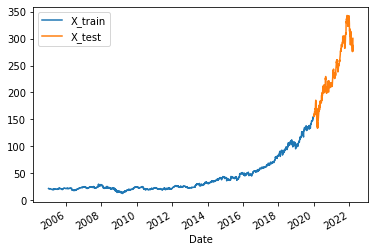

<Figure size 1440x1080 with 0 Axes>

In [39]:
# train 데이터와 test 데이터 그래프 그리기
X_train['Close'].plot(kind = 'line')
X_test['Close'].plot(kind = 'line')

plt.legend(['X_train', 'X_test'])
plt.figure(figsize = (20, 15))
plt.show()

In [40]:
# 정확도가 낮다면?
# data set를 바꾸기(데이터 증강)
# 하이퍼 파라미터 조정
# 알고리즘 변경

In [41]:
# sequences data로 만들기 (월, 화, 수, 목(4일씩) -> 하나로.) - 금요일 데이터 분석!
# 학습 데이터(sequences data), 정답 데이터 -> 월 ~ 목까지 1 set
# LSTM -> Numpy 배열(3차원 배열)
# StandardScaler 사용(정규화)

def Scaler_to_np(df):
    df_list = []
    df = np.array(df)
    for i in range(0, len(df) - 3, 4):
        df_s = df[i : i + 4]
        scaler = StandardScaler()
        df_scaler = scaler.fit_transform(df_s)
        df_list.append(df_scaler)
        
    return np.array(df_list) # 차원을 3차원으로 만듦.(왜냐 모델에 넣을거니까)

In [42]:
X_train_array = Scaler_to_np(X_train)
X_test_array = Scaler_to_np(X_test)

# 3차원 배열
print(X_train_array.shape)
print(X_test_array.shape)

(808, 4, 7)
(120, 4, 7)


In [43]:
print(X_train_array)

[[[-1.34164079  0.72057743 -0.24410355 ...  1.28710749  1.67805126
   -1.49627562]
  [-0.4472136   0.72057743  1.68547688 ...  0.35837111 -0.56366592
   -0.1061873 ]
  [ 0.4472136   0.26000216 -0.54632699 ... -0.16656685 -0.2068376
    0.31856191]
  [ 1.34164079 -1.70115702 -0.89504634 ... -1.47891174 -0.90754774
    1.28390102]]

 [[-1.34164079  1.1756896   0.30666695 ...  0.71531848  0.93976161
   -1.0356472 ]
  [-0.4472136  -0.59476062  0.67135198 ...  0.38073403  0.10428345
   -0.4017812 ]
  [ 0.4472136   0.73307704  0.73102771 ...  0.62301932  0.60956
   -0.21212051]
  [ 1.34164079 -1.31400602 -1.70904663 ... -1.71907184 -1.65360506
    1.64954892]]

 [[ 1.52127766  1.5491149   1.38011342 ...  0.95354725 -1.10391619
    1.22370761]
  [-1.18321596 -1.24321373 -1.26336667 ... -1.68076616 -0.1846576
    0.19905644]
  [-0.50709255 -0.09020163 -0.55454709 ...  0.38958156  1.6233322
   -1.56308252]
  [ 0.16903085 -0.21569954  0.43780033 ...  0.33763735 -0.33475841
    0.14031847]]

 ...

In [44]:
# series 형태
print(y_train)

Date
2005-01-04    0.0
2005-01-05    0.0
2005-01-06    0.0
2005-01-07    1.0
2005-01-10    0.0
             ... 
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    1.0
2019-12-19    1.0
2019-12-20    1.0
Name: Up, Length: 3234, dtype: float64


In [45]:
# 금요일만 가져오기
y_train_array = y_train[3::4] # 4개씩 데이터 끊어주기
y_test_array = y_test[3::4]

print(len(y_train_array))
print(len(y_test_array))

808
120


In [46]:
y_train_array.value_counts()

1.0    433
0.0    375
Name: Up, dtype: int64

In [47]:
df.shape

(3714, 8)

### LSTM 모델 생성

In [48]:
# 배치정규화
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

In [58]:
# batch_input_shape = (batch_size, sequence(time_steps), 입력 수(features))
def lstm_model(df):
    model = Sequential()
    # batch - 일괄 처리되는 작업의 양
    model.add(LSTM(64, return_sequences = True, activation = 'tanh',
                  input_shape = (4, 7)))
    model.add(LSTM(128, return_sequences = True, activation = 'tanh'))
    model.add(LSTM(64, return_sequences = False, activation = 'tanh'))
    
    model.add(Dropout(0.3)) # 과대적합을 막기 위해
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1, activation = 'softmax'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])
    
    return model

In [59]:
# 시계열 데이터 모델 검증하기 - 교차검증 (Timeseries Validation -> TimeSeriesSplit)
# 그룹의 최적화된 파라미터를 사용하겠다.
valid_scores = [] # 4번의 교차검증 결과 저장
tscv = TimeSeriesSplit(n_splits = 4)

In [60]:
# enumerate() - 인덱스와 원소로 이루어진 튜플을 만들어줌.
# 인자로 넘어온 목록을 기준으로 인덱스와 원소를 차례대로 접근하게 해주는 반복자(iterator) 
# 훈련 & 검증 - 훈련 다음 데이터가 검증 데이터.(검증 데이터는 랜덤 or not)
for fold, (train_indices, value_indices) in enumerate(tscv.split(X_train_array)):
    X_train, X_valid = X_train_array[train_indices], X_train_array[value_indices]
    y_train, y_valid = y_train_array[train_indices], y_train_array[value_indices]
    
    model = lstm_model(X_train)
    model.fit(X_train, y_train, epochs = 30, batch_size = 64)
    
    y_pred = model.predict(X_valid)
    
    y_pred = np.where(y_pred < 0.5, 0, 1)
    
    # accuracy_score - 정답배열과 예측값의 배열을 넣으면 정확도가 평가됨.
    score = accuracy_score(y_valid, y_pred)
    print(f'fold: {fold} score: {score}')
    
    valid_scores.append(score)

Epoch 1/30


C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 3s 9ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5000
Epoch 7/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5000
Epoch 8/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5000
Epoch 9/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5000
Epoch 10/30
3/3 [==============================] - 0s 8ms/step - loss: 0.6913 - accuracy: 0.5000
Epoch 11/30
3/3 [==============================] -

C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 [==============================] - 3s 9ms/step - loss: 0.6930 - accuracy: 0.5292
Epoch 2/30
6/6 [==============================] - 0s 9ms/step - loss: 0.6923 - accuracy: 0.5292
Epoch 3/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6913 - accuracy: 0.5292
Epoch 4/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6904 - accuracy: 0.5292
Epoch 5/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6890 - accuracy: 0.5292
Epoch 6/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6888 - accuracy: 0.5292
Epoch 7/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6911 - accuracy: 0.5292
Epoch 8/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.5292
Epoch 9/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6872 - accuracy: 0.5292
Epoch 10/30
6/6 [==============================] - 0s 8ms/step - loss: 0.6878 - accuracy: 0.5292
Epoch 11/30
6/6 [==============================] -

C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 3s 9ms/step - loss: 0.6940 - accuracy: 0.5165
Epoch 2/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6929 - accuracy: 0.5165
Epoch 3/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6926 - accuracy: 0.5165
Epoch 4/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5165
Epoch 5/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6927 - accuracy: 0.5165
Epoch 6/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6917 - accuracy: 0.5165
Epoch 7/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6898 - accuracy: 0.5165
Epoch 8/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6890 - accuracy: 0.5165
Epoch 9/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6887 - accuracy: 0.5165
Epoch 10/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5165
Epoch 11/30
8/8 [==============================] -

C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 3s 9ms/step - loss: 0.6934 - accuracy: 0.5209
Epoch 2/30
11/11 [==============================] - 0s 9ms/step - loss: 0.6927 - accuracy: 0.5209
Epoch 3/30
11/11 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.5209
Epoch 4/30
11/11 [==============================] - 0s 9ms/step - loss: 0.6921 - accuracy: 0.5209
Epoch 5/30
11/11 [==============================] - 0s 9ms/step - loss: 0.6920 - accuracy: 0.5209
Epoch 6/30
11/11 [==============================] - 0s 8ms/step - loss: 0.6920 - accuracy: 0.5209
Epoch 7/30
11/11 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.5209
Epoch 8/30
11/11 [==============================] - 0s 9ms/step - loss: 0.6928 - accuracy: 0.5209
Epoch 9/30
11/11 [==============================] - 0s 8ms/step - loss: 0.6912 - accuracy: 0.5209
Epoch 10/30
11/11 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5209
Epoch 11/30
11/11 [===========

In [61]:
print(f'valid_scores: {valid_scores}')
cv_score = np.mean(valid_scores)
print(f'cv_score: {cv_score}')

valid_scores: [0.5590062111801242, 0.4906832298136646, 0.5341614906832298, 0.5962732919254659]
cv_score: 0.5450310559006211


In [62]:
# 훈련 데이터를 모델에 대입.
model = lstm_model(X_train_array)
r = model.fit(X_train_array, y_train_array, epochs = 30, batch_size = 64)

Epoch 1/30


C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 3s 10ms/step - loss: 0.6924 - accuracy: 0.5359
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 0.6909 - accuracy: 0.5359
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 0.6900 - accuracy: 0.5359
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 0.6904 - accuracy: 0.5359
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 0.6893 - accuracy: 0.5359
Epoch 6/30
13/13 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.5359
Epoch 7/30
13/13 [==============================] - 0s 10ms/step - loss: 0.6877 - accuracy: 0.5359
Epoch 8/30
13/13 [==============================] - 0s 9ms/step - loss: 0.6890 - accuracy: 0.5359
Epoch 9/30
13/13 [==============================] - 0s 9ms/step - loss: 0.6875 - accuracy: 0.5359
Epoch 10/30
13/13 [==============================] - 0s 9ms/step - loss: 0.6879 - accuracy: 0.5359
Epoch 11/30
13/13 [========

In [63]:
# 예측
pred = model.predict(X_test_array)
pred[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [64]:
pred = np.where(pred < 0.5, 0, 1)
pred[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [65]:
print(f'accuracy= {accuracy_score(y_true = y_test_array, y_pred = pred)}')

accuracy= 0.5833333333333334


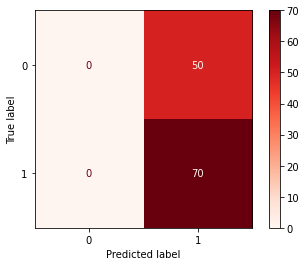

In [66]:
cm = confusion_matrix(y_test_array, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap = plt.cm.Reds)